In [1]:
import matplotlib.pyplot as plt
import numpy as np
import keras
from time import time
from keras.layers import Dense, Input,Conv1D, MaxPooling1D, Flatten, Embedding, Reshape, UpSampling1D, LeakyReLU, ReLU
from keras.models import Sequential, Model
from tensorflow.python.keras.callbacks import TensorBoard
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import load_model
import keras.backend as K

import tensorflow as tf

Using TensorFlow backend.


In [2]:
P = np.array([
    [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1],
    [1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1],
    [1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1],
    [1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0],
    [0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0],
    [0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1],
    [1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0],
    [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0],
    [0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1],
    [1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0],
    [0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1],
], dtype='int')

In [3]:
def awgn(x_input, reqSNR):
    sig_power = 1
    
    noise_power = np.sqrt(sig_power / (2*reqSNR))

    noise = noise_power * np.random.normal(size = x_input.shape)
    
    return x_input + noise

In [4]:
def custom_ReLU(x):
#     return tf.minimum(tf.maximum(x,-1),1)  
    return tf.minimum(x, 1)
#     return 10*x*tf.exp(-0.1*tf.square(x))
#     return x*tf.exp(tf.square(x))
#     return tf.exp(-1*tf.square(x))

In [5]:
def custom_func(x):
    return tf.maximum(x,-1)
#     return x*tf.exp(tf.square(x))

In [6]:
m = np.random.randint(2, size=(10**7, 12))
G= np.concatenate((P, np.eye(12, dtype="int")), axis=1)
x_train = np.dot(m, G) % 2
x_train = np.where(x_train > 0, -1, 1)
    
m = np.random.randint(2, size=(10**3, 12))
x_test = np.dot(m, G) % 2
x_test = np.where(x_test > 0, -1, 1)    
    
Eb_No = 10**(3/10)
Es_No = Eb_No * (12/23)
x_train_noisy = awgn(x_train, Es_No)
x_test_noisy = awgn(x_test, Es_No)

In [7]:
# x_train_noisy = (x_train_noisy + 1) / 2 
# x_train = (x_train + 1) / 2
# x_test_noisy = (x_test_noisy + 1) / 2
# x_test = (x_test + 1) / 2

In [9]:
model = Sequential()

model.add(Dense(12, activation=custom_func,input_dim=23))
model.add(Dense(6, activation=custom_ReLU))
model.add(Dense(3, activation=custom_func))
model.add(Dense(2, activation=custom_ReLU))
model.add(Dense(3, activation=custom_func))
model.add(Dense(6, activation=custom_ReLU))
model.add(Dense(12, activation=custom_func))
model.add(Dense(23, activation='linear'))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])


In [ ]:
model.fit(x_train_noisy, x_train, 
          epochs=100,
          batch_size=10000,
          shuffle=True,
          validation_data=(x_test_noisy, x_test))

output 0.49666666666666665
input 0.07458333333333333
x:  [-1 -1 -1  1  1  1 -1 -1 -1  1 -1  1 -1 -1 -1  1  1  1 -1  1  1 -1  1] 
n:  [0 1 1 1 0 0 0 1 0 0 1 0] 
decode: [1 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 1]


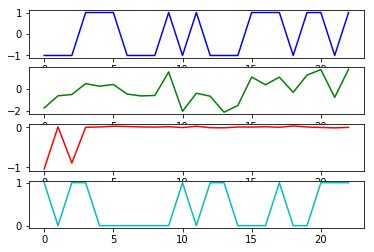

In [41]:
decoded_imgs = model.predict(x_test_noisy)
  
decoded_imgs = np.reshape(decoded_imgs, (len(x_test), 23))

n = 25

            
for i in range(24, n):
    # display original
    
    plt.subplot(411)
    plt.plot(x_test[i].reshape(23), 'b')



    # display noisy
    
    plt.subplot(412)
    plt.plot(x_test_noisy[i].reshape(23), 'g')



    # display reconstruction

    plt.subplot(413)
    plt.plot(decoded_imgs[i].reshape(23), 'r')
    
    decoded_imgs = np.where(decoded_imgs < 0, 1, 0)     
    count = ((m+decoded_imgs[:,11:])%2).sum()
    print('output', count/(m.shape[0]*m.shape[1]))
    x_input = np.where(x_test_noisy < 0, 1, 0)
    count = ((m+x_input[:,11:])%2).sum()
    print('input', count/(m.shape[0]*m.shape[1]))
    
    plt.subplot(414)
    plt.plot(decoded_imgs[i].reshape(23), 'c')
    
    print("x: ", x_test[i], "\nn: ", m[i],"\ndecode:", decoded_imgs[i])

plt.show()



In [ ]:

model.save('model_cus_relu.h5')